In [1]:
import os, glob, shutil
import numpy as np
import pandas as pd
import math

from PIL import Image

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, concatenate, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


In [2]:
# 랜덤시드 고정시키기
np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'top10_food_train',
        target_size=(32, 32),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'top10_food_test',
        target_size=(32, 32),    
        batch_size=3,
        class_mode='categorical')

Using TensorFlow backend.


Found 199 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32,32,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# 모델 학습
model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=5,
        validation_data=test_generator,
        validation_steps=5)

Epoch 1/5
1500/1500 [==============================] - 69s 46ms/step - loss: 1.0617 - acc: 0.6031 - val_loss: 2.1029 - val_acc: 0.2667
Epoch 2/5
1500/1500 [==============================] - 71s 47ms/step - loss: 0.6739 - acc: 0.7612 - val_loss: 2.6277 - val_acc: 0.3333
Epoch 3/5
1500/1500 [==============================] - 69s 46ms/step - loss: 0.5000 - acc: 0.8223 - val_loss: 2.8772 - val_acc: 0.3333
Epoch 4/5
1500/1500 [==============================] - 70s 47ms/step - loss: 0.3633 - acc: 0.8770 - val_loss: 2.8972 - val_acc: 0.2667
Epoch 5/5
1500/1500 [==============================] - 70s 47ms/step - loss: 0.3138 - acc: 0.8898 - val_loss: 4.0143 - val_acc: 0.4000


In [18]:
# 모델 평가
scores = model.evaluate_generator(test_generator, steps = 5)
print('accuracy: ', scores[1])
print('loss: ', scores[0])

accuracy:  0.4
loss:  4.014320874214173


In [37]:
# 모델 예측
# output = model.predict_generator(test_generator, steps = 5)
output = model.predict_generator(test_generator, verbose=1)

34/34 [==============================] - 1s 22ms/step


100

In [43]:
predicted_class_indices = [np.argmax(i) for i in output]

In [46]:
labels = train_generator.class_indices
labels

{'갈비구이': 0,
 '곰탕_설렁탕': 1,
 '불고기': 2,
 '삼겹살': 3,
 '삼계탕': 4,
 '제육볶음': 5,
 '짜장면': 6,
 '짬뽕': 7,
 '칼국수': 8,
 '훈제오리': 9}

In [54]:
labels = dict((val, key) for key, val in labels.items())
labels

{0: '갈비구이',
 1: '곰탕_설렁탕',
 2: '불고기',
 3: '삼겹살',
 4: '삼계탕',
 5: '제육볶음',
 6: '짜장면',
 7: '짬뽕',
 8: '칼국수',
 9: '훈제오리'}

In [56]:
predictions = [labels[key] for key in predicted_class_indices]

In [62]:
filenames = test_generator.filenames
filenames[0]

food = [file.split('\\')[0] for file in filenames]

In [63]:
results = pd.DataFrame({'음식':food, "예측":predictions})
results

,음식,예측
0,갈비구이,삼계탕
1,갈비구이,제육볶음
2,갈비구이,짜장면
3,갈비구이,불고기
4,갈비구이,삼겹살
...,...,...
95,훈제오리,칼국수
96,훈제오리,칼국수
97,훈제오리,갈비구이
98,훈제오리,짬뽕


# Densenet

In [2]:
food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [3]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_train'
img_path = image_folder + '/'
image_size = 32

x_train = []
y_train = []

print('train 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_train.append(data)
        y_train.append(i)
        
print()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

train 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [5]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_test'
img_path = image_folder + '/'
image_size = 32

x_test = []
y_test = []

print('test 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_test.append(data)
        y_test.append(i)
        
print()

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

test 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [11]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [12]:
dense.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 16, 16, 64)   256         conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 16, 16, 64)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [14]:
dense.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)

In [25]:
x_train.shape, y_train_reshape.shape, x_test.shape, y_test_reshape.shape

((200, 32, 32, 3), (200, 1), (100, 32, 32, 3), (100, 1))

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_reshape, test_size= 0.2)

In [29]:
history = dense.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 20,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/20
5/5 [==============================] - 7s 1s/step - loss: 97.3297 - acc: 0.6250 - val_loss: 96.0601 - val_acc: 0.0750
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 92.8835 - acc: 0.6812 - val_loss: 91.9449 - val_acc: 0.0750
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 88.7058 - acc: 0.7063 - val_loss: 87.9804 - val_acc: 0.0500
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 84.6762 - acc: 0.7688 - val_loss: 84.1843 - val_acc: 0.0750
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 80.8133 - acc: 0.7937 - val_loss: 80.4801 - val_acc: 0.0750
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 77.5884 - acc: 0.8062 - val_loss: 78.0578 - val_acc: 0.0500
Epoch 7/20
5/5 [==============================] - 8s 2s/step - loss: 75.0083 - acc: 0.8125 - val_loss: 75.6693 - val_acc: 0.0500
Epoch 8/20
5/5 [==============================] - 7s 1s/step - loss: 72.6264 - acc: 0.8188 - val_

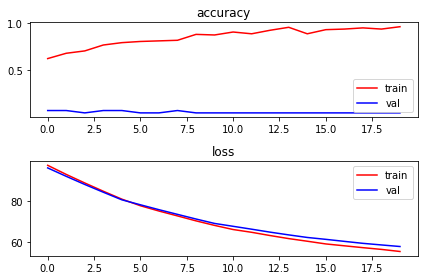

In [30]:
# import matplotlib.pyplot as plt
# %matplotlib inline


plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")


plt.tight_layout()
plt.show()


In [31]:
score = dense.evaluate(x_test, y_test_reshape)

print('test score:', score[0])
print('test accuracy:', score[1])

100/100 [==============================] - 1s 5ms/sample - loss: 220.6940 - acc: 0.1100
test score: 220.6939730834961
test accuracy: 0.11


# Densenet 2 
### ImageDataGenerator로 사진증가

In [41]:
food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [42]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# 'train'
image_folder = 'top10_food_train'
img_path = image_folder + '/'

for food in food_list:
    print(food, end=', ')
   
    food_path = img_path + food + '/'
    images = glob.glob(food_path+'/*')
    for i in images:
        img = load_img(i)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, ) + img_array.shape)

        count= 0
        food_num = images[0].split('\\')[1].split('_')[1]
#             print(food_num)
        
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=food_path , save_prefix='Img_'+food_num, save_format='jpg'):
            count += 1
            if count > 20:
                break

갈비구이, 제육볶음, 짬뽕, 삼겹살, 짜장면, 삼계탕, 불고기, 곰탕_설렁탕, 칼국수, 훈제오리, 

In [44]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_train'
img_path = image_folder + '/'
image_size = 32

x_train = []
y_train = []

print('train 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_train.append(data)
        y_train.append(i)
        
print()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

train 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [45]:
## 사진 사이즈 변경해서 np array로 변경

image_folder = 'top10_food_test'
img_path = image_folder + '/'
image_size = 32

x_test = []
y_test = []

print('test 이미지 입력')

for i, food in enumerate(food_list):
    path = img_path + food  
    print(food, end = ',')

    files = []
    files.extend(glob.glob(path + '/*'))

    for file in files:
        img = Image.open(file)
        img = img.convert("RGB") # 색상 모드 변경
        img = img.resize((image_size, image_size)) # 이미지 크기 변경

        data = np.asarray(img)

        x_test.append(data)
        y_test.append(i)
        
print()

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

test 이미지 입력
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [46]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [47]:
dense.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_285 (BatchN (None, 16, 16, 64)   256         conv2d_285[0][0]                 
__________________________________________________________________________________________________
activation_285 (Activation)     (None, 16, 16, 64)   0           batch_normalization_285[0][0]    
____________________________________________________________________________________________

In [48]:
dense.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)

In [50]:
x_train.shape, y_train_reshape.shape, x_test.shape, y_test_reshape.shape

((4307, 32, 32, 3), (4307, 1), (100, 32, 32, 3), (100, 1))

In [51]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_reshape, test_size= 0.2)

In [52]:
history = dense.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 5,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/5
107/107 [==============================] - 556s 5s/step - loss: 81.2898 - acc: 0.4779 - val_loss: 51.0391 - val_acc: 0.0958
Epoch 2/5
107/107 [==============================] - 252s 2s/step - loss: 34.1994 - acc: 0.6425 - val_loss: 24.8180 - val_acc: 0.0864
Epoch 3/5
107/107 [==============================] - 257s 2s/step - loss: 16.8882 - acc: 0.7351 - val_loss: 14.5197 - val_acc: 0.1157
Epoch 4/5
107/107 [==============================] - 257s 2s/step - loss: 9.8007 - acc: 0.7797 - val_loss: 9.2664 - val_acc: 0.2909
Epoch 5/5
107/107 [==============================] - 276s 3s/step - loss: 6.4613 - acc: 0.7949 - val_loss: 6.4401 - val_acc: 0.4019


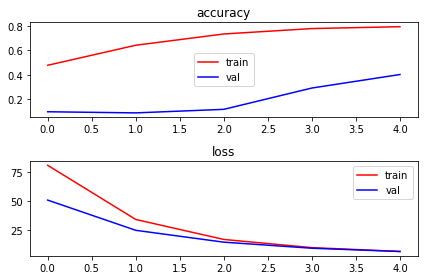

In [53]:
# import matplotlib.pyplot as plt
# %matplotlib inline


plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")


plt.tight_layout()
plt.show()


In [54]:
score = dense.evaluate(x_test, y_test_reshape)

print('test score:', score[0])
print('test accuracy:', score[1])

100/100 [==============================] - 2s 17ms/sample - loss: 1158.2268 - acc: 0.0900
test score: 1158.226767578125
test accuracy: 0.09


# Densenet 3

In [2]:
# food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [32]:
# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

# # 'train'
# image_folder = 'top10_food_train'
# img_path = image_folder + '/'

# for food in food_list:
#     print(food, end=', ')
   
#     food_path = img_path + food + '/'
#     images = glob.glob(food_path+'/*')
#     for i in images:
#         img = load_img(i)
#         img_array = img_to_array(img)
#         img_array = img_array.reshape((1, ) + img_array.shape)

#         count= 0
#         food_num = images[0].split('\\')[1].split('_')[1]
# #             print(food_num)
        
#         for batch in datagen.flow(img_array, batch_size=1, save_to_dir=food_path , save_prefix='Img_'+food_num, save_format='jpg'):
#             count += 1
#             if count > 20:
#                 break

갈비구이, 제육볶음, 짬뽕, 삼겹살, 짜장면, 삼계탕, 불고기, 곰탕_설렁탕, 칼국수, 훈제오리, 

In [ ]:
# ## 사진 사이즈 변경해서 np array로 변경

# image_folder = 'top10_food_train'
# img_path = image_folder + '/'
# image_size = 32

# x_train = []
# y_train = []

# print('train 이미지 입력')

# for i, food in enumerate(food_list):
#     path = img_path + food  
#     print(food, end = ',')

#     files = []
#     files.extend(glob.glob(path + '/*'))

#     for file in files:
        
#         img = Image.open(file)
#         img = img.convert("RGB") # 색상 모드 변경
#         img = img.resize((image_size, image_size)) # 이미지 크기 변경

#         data = np.asarray(img)

#         x_train.append(data)
#         y_train.append(i)
        
# print()

# x_train = np.asarray(x_train)
# y_train = np.asarray(y_train)

In [ ]:
# ## 사진 사이즈 변경해서 np array로 변경

# image_folder = 'top10_food_test'
# img_path = image_folder + '/'
# image_size = 32

# x_test = []
# y_test = []

# print('test 이미지 입력')

# for i, food in enumerate(food_list):
#     path = img_path + food  
#     print(food, end = ',')

#     files = []
#     files.extend(glob.glob(path + '/*'))

#     for file in files:
#         img = Image.open(file)
#         img = img.convert("RGB") # 색상 모드 변경
#         img = img.resize((image_size, image_size)) # 이미지 크기 변경

#         data = np.asarray(img)

#         x_test.append(data)
#         y_test.append(i)
        
# print()

# x_test = np.asarray(x_test)
# y_test = np.asarray(y_test)

In [55]:
x_train = np.array(x_train) / 127.5 - 1
x_test = np.array(x_test) / 127.5 - 1

In [ ]:
# y_train_reshape = y_train.reshape(-1, 1)
# y_test_reshape = y_test.reshape(-1, 1)

In [56]:
datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True )

# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)


def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x


def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense = Model(input_img, x)

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [57]:
dense.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_380 (Conv2D)             (None, 16, 16, 64)   9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_380 (BatchN (None, 16, 16, 64)   256         conv2d_380[0][0]                 
__________________________________________________________________________________________________
activation_380 (Activation)     (None, 16, 16, 64)   0           batch_normalization_380[0][0]    
____________________________________________________________________________________________

In [58]:
dense.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
x_train.shape, y_train.shape, x_test.shape, y_test_reshape.shape

((3445, 32, 32, 3), (3445, 1), (100, 32, 32, 3), (100, 1))

In [70]:
x_val.shape, y_val.shape

((862, 32, 32, 3), (862, 1))

In [62]:
# x_train

array([[[[ 0.73333333,  0.7254902 ,  0.69411765],
         [ 0.75686275,  0.7254902 ,  0.70196078],
         [ 0.75686275,  0.7254902 ,  0.70196078],
         ...,
         [ 0.77254902,  0.67843137,  0.56862745],
         [ 0.76470588,  0.67058824,  0.56078431],
         [ 0.75686275,  0.67843137,  0.6       ]],

        [[ 0.74117647,  0.70980392,  0.68627451],
         [ 0.7254902 ,  0.73333333,  0.69411765],
         [ 0.75686275,  0.7254902 ,  0.70196078],
         ...,
         [ 0.75686275,  0.67843137,  0.6       ],
         [ 0.76470588,  0.68627451,  0.60784314],
         [ 0.76470588,  0.68627451,  0.60784314]],

        [[ 0.73333333,  0.7254902 ,  0.69411765],
         [ 0.73333333,  0.7254902 ,  0.70980392],
         [ 0.75686275,  0.7254902 ,  0.70196078],
         ...,
         [ 0.76470588,  0.68627451,  0.60784314],
         [ 0.76470588,  0.68627451,  0.60784314],
         [ 0.77254902,  0.69411765,  0.61568627]],

        ...,

        [[ 0.83529412,  0.76470588,  0

In [60]:
# x_val

array([[[[249, 249, 247],
         [254, 254, 254],
         [253, 253, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[250, 250, 250],
         [252, 252, 250],
         [253, 253, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[251, 251, 251],
         [250, 250, 248],
         [249, 249, 249],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[110, 101,  94],
         [129, 120, 121],
         [126, 126, 128],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[ 81,  72,  65],
         [126, 125, 123],
         [184, 184, 186],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[ 47,  38,  33],
         [ 85,  83,  84],
         [228, 226, 227],
         ...,
         [255, 255, 255],
        

In [61]:
x_val = np.array(x_val) / 127.5 - 1

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_reshape, test_size= 0.2)

In [63]:
history = dense.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 5,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/5
107/107 [==============================] - 803s 8s/step - loss: 81.7010 - acc: 0.5151 - val_loss: 52.2874 - val_acc: 0.0993
Epoch 2/5
107/107 [==============================] - 320s 3s/step - loss: 34.9581 - acc: 0.6683 - val_loss: 25.1583 - val_acc: 0.1250
Epoch 3/5
107/107 [==============================] - 314s 3s/step - loss: 17.2800 - acc: 0.7515 - val_loss: 14.0716 - val_acc: 0.2593
Epoch 4/5
107/107 [==============================] - 309s 3s/step - loss: 10.0584 - acc: 0.7612 - val_loss: 9.3807 - val_acc: 0.2512
Epoch 5/5
107/107 [==============================] - 310s 3s/step - loss: 6.4685 - acc: 0.8210 - val_loss: 6.0471 - val_acc: 0.5537


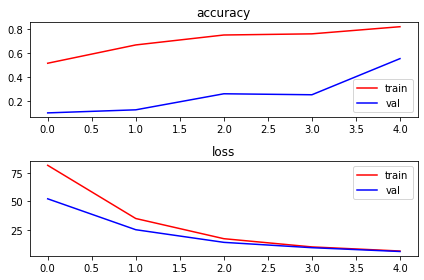

In [64]:
# import matplotlib.pyplot as plt
# %matplotlib inline


plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")


plt.tight_layout()
plt.show()


In [65]:
score = dense.evaluate(x_test, y_test_reshape)

print('test score:', score[0])
print('test accuracy:', score[1])

100/100 [==============================] - 2s 24ms/sample - loss: 6.4335 - acc: 0.4700
test score: 6.433518028259277
test accuracy: 0.47


### Epoch 20

In [71]:
history = dense.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 20,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/20
107/107 [==============================] - 341s 3s/step - loss: 4.6685 - acc: 0.8087 - val_loss: 4.5097 - val_acc: 0.6262
Epoch 2/20
107/107 [==============================] - 326s 3s/step - loss: 3.5253 - acc: 0.8485 - val_loss: 3.9190 - val_acc: 0.5829
Epoch 3/20
107/107 [==============================] - 340s 3s/step - loss: 2.7878 - acc: 0.8602 - val_loss: 2.6501 - val_acc: 0.7956
Epoch 4/20
107/107 [==============================] - 319s 3s/step - loss: 2.2798 - acc: 0.8646 - val_loss: 2.5240 - val_acc: 0.7407
Epoch 5/20
107/107 [==============================] - 320s 3s/step - loss: 2.0213 - acc: 0.8602 - val_loss: 2.1897 - val_acc: 0.7407
Epoch 6/20
107/107 [==============================] - 318s 3s/step - loss: 1.6476 - acc: 0.9071 - val_loss: 1.5325 - val_acc: 0.9112
Epoch 7/20
107/107 [==============================] - 307s 3s/step - loss: 1.4169 - acc: 0.9203 - val_loss: 1.5945 - val_acc: 0.8446
Epoch 8/20
107/107 [==============================] - 317s 3s/step - 

In [73]:
score = dense.evaluate(x_test, y_test_reshape)

print('test score:', score[0])
print('test accuracy:', score[1])

100/100 [==============================] - 2s 22ms/sample - loss: 3.1081 - acc: 0.5500
test score: 3.1080543422698974
test accuracy: 0.55


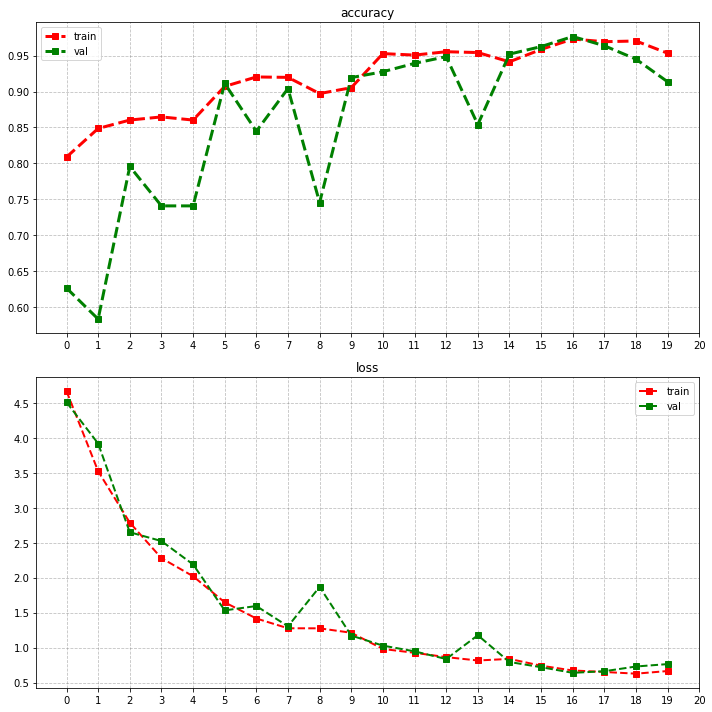

In [107]:
# import matplotlib.pyplot as plt
# %matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], "rs--", label="train", lw = 3)
plt.plot(history.history["val_acc"], "gs--", label="val", lw = 3)
plt.xticks([i for i in range(21)])
plt.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], "rs--", label="train", lw = 2)
plt.plot(history.history["val_loss"], "gs--", label="val", lw = 2)
plt.xticks([i for i in range(21)])
plt.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
plt.legend(loc="best")


plt.tight_layout()
# plt.show()
plt.savefig('acc_loss_plot.png')


In [102]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 불고기		/	실제 값: 갈비구이
예측: 짜장면		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 제육볶음		/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음

예측: 제육볶음		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 훈제오리		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 삼겹살		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예

##### Accuracy가 가장 높았던  Epoch 17 로  Test

In [120]:
model_filename = "h_file/model_17.h5"
dense.load_weights(model_filename)

predicted = [np.argmax(i) for i in dense.predict(x_test)]

In [121]:
score = dense.evaluate(x_test, y_test_reshape)

100/100 [==============================] - 2s 23ms/sample - loss: 2.1077 - acc: 0.6100


In [102]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 불고기		/	실제 값: 갈비구이
예측: 짜장면		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 제육볶음		/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음

예측: 제육볶음		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 훈제오리		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 삼겹살		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예

In [108]:
food_endict = {'갈비구이' : 'Galbigu-i', 
               '곰탕_설렁탕' : 'Gomtang_Seolleongtang', 
               '불고기' : 'Bulgogi', 
               '삼겹살' : 'Samgyeobsal', 
               '삼계탕' : 'Samgyetang', 
               '제육볶음' : 'Jeyugbokk-eum', 
               '짜장면' : 'Jjajangmyeon', 
               '짬뽕' : 'Jjamppong', 
               '칼국수' : 'Kalgugsu', 
               '훈제오리' : 'Hunje-oli'}

In [109]:
def view_img(path, file):
    plt.figure(figsize=(10, 10))
    plt.imshow(Image.open(path + file))

def get_img_array(path):
    img = Image.open(path)
    img = img.convert("RGB") 
    img = img.resize((32, 32))
    data = np.asarray(img)
    data_rescale = np.array(data) / 127.5 - 1
    return data_rescale.reshape(-1, 32, 32, 3)

def predict_result(model, data):
    result = food_list[np.argmax(model.predict(data))]
    return (result, food_endict[result])

('삼겹살', 'Samgyeobsal')

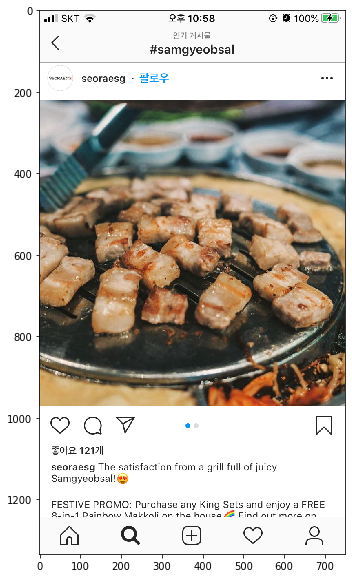

In [110]:
view_img('predict_img/', 'img1.png')
data = get_img_array('predict_img/img1.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

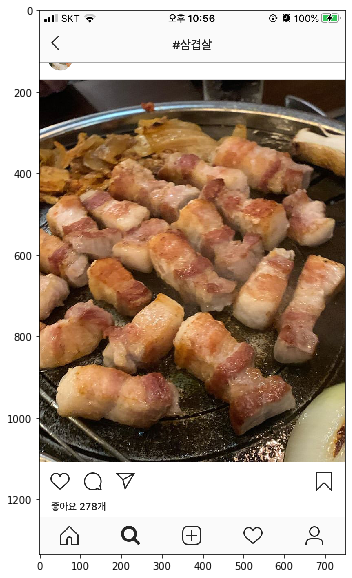

In [111]:
view_img('predict_img/', 'img2.png')
data = get_img_array('predict_img/img2.png')
predict_result(dense, data)

('삼겹살', 'Samgyeobsal')

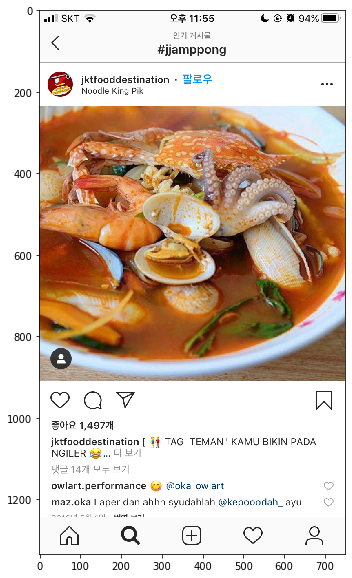

In [112]:
view_img('predict_img/', 'img3.png')
data = get_img_array('predict_img/img3.png')
predict_result(dense, data)

('제육볶음', 'Jeyugbokk-eum')

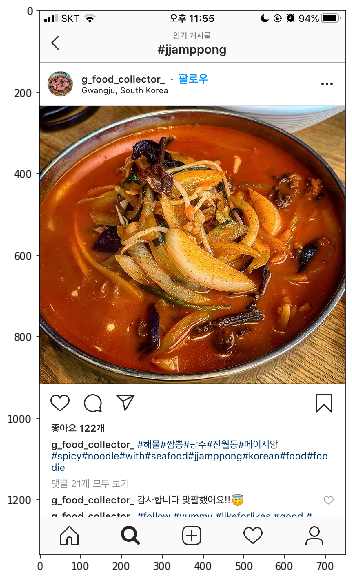

In [113]:
view_img('predict_img/', 'img4.png')
data = get_img_array('predict_img/img4.png')
predict_result(dense, data)

In [ ]:
view_img('predict_img/', 'img5.png')
data = get_img_array('predict_img/img5.png')
predict_result(dense, data)

In [ ]:
view_img('predict_img/', 'img6.png')
data = get_img_array('predict_img/img6.png')
predict_result(dense, data)

epoch 100이 실패한 이미지

In [ ]:
view_img('predict_img/false/', 'img5_.png')
data = get_img_array('predict_img/false/img5_.png')
predict_result(dense, data)

In [ ]:
view_img('predict_img/false/', 'img8_.png')
data = get_img_array('predict_img/false/img8_.png')
predict_result(dense, data)

In [ ]:
view_img('predict_img/false/', 'img9_.png')
data = get_img_array('predict_img/false/img9_.png')
predict_result(dense, data)

# Accuracy로는 위의 모델이 성능이 좋지만
# 실제 검색한 이미지에 대해서는
# Epoch 100으로 실시한 결과가 더 좋았다


### Epoch 100

In [ ]:
history = dense.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 100,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/100
107/107 [==============================] - 324s 3s/step - loss: 1.6916 - acc: 0.7694 - val_loss: 9.0490 - val_acc: 0.2734
Epoch 2/100
107/107 [==============================] - 327s 3s/step - loss: 1.4213 - acc: 0.8359 - val_loss: 1.6164 - val_acc: 0.7477
Epoch 3/100
107/107 [==============================] - 324s 3s/step - loss: 1.0637 - acc: 0.8983 - val_loss: 1.2546 - val_acc: 0.8096
Epoch 4/100
107/107 [==============================] - 329s 3s/step - loss: 0.9904 - acc: 0.9024 - val_loss: 1.1704 - val_acc: 0.8505
Epoch 5/100
107/107 [==============================] - 322s 3s/step - loss: 0.9605 - acc: 0.9042 - val_loss: 2.8648 - val_acc: 0.5269
Epoch 6/100
107/107 [==============================] - 321s 3s/step - loss: 0.8432 - acc: 0.9347 - val_loss: 0.8696 - val_acc: 0.9100
Epoch 7/100
107/107 [==============================] - 319s 3s/step - loss: 0.7769 - acc: 0.9376 - val_loss: 0.7688 - val_acc: 0.9311
Epoch 8/100
107/107 [==============================] - 330s 3s

In [ ]:
score = dense.evaluate(x_test, y_test_reshape)

print('test score:', score[0])
print('test accuracy:', score[1])

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], "rs--", label="train", lw = 3)
plt.plot(history.history["val_acc"], "gs--", label="val", lw = 3)
plt.xticks([i for i in range(101)])
plt.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], "rs--", label="train", lw = 2)
plt.plot(history.history["val_loss"], "gs--", label="val", lw = 2)
plt.xticks([i for i in range(101)])
plt.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
plt.legend(loc="best")


plt.tight_layout()
# plt.show()
plt.savefig('acc_loss_plot_100.png')


In [ ]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

<Figure size 432x288 with 0 Axes>